In [1]:
import sys, os 
current_dir = os.getcwd()
path = os.path.dirname(current_dir)
sys.path.append(path)

In [25]:
import skexplain
import plotting_config
import matplotlib.pyplot as plt
import numpy as np 
import shap
from bayeshist import bayesian_histogram, plot_bayesian_histogram

In [3]:
estimators = skexplain.load_models()
X,y = skexplain.load_data()
X = X.astype({'urban': 'category', 'rural':'category'})

In [13]:
list(X.columns)

['dllwave_flux',
 'dwpt2m',
 'fric_vel',
 'gflux',
 'high_cloud',
 'lat_hf',
 'low_cloud',
 'mid_cloud',
 'sat_irbt',
 'sens_hf',
 'sfcT_hrs_ab_frez',
 'sfcT_hrs_bl_frez',
 'sfc_rough',
 'sfc_temp',
 'swave_flux',
 'temp2m',
 'tmp2m_hrs_ab_frez',
 'tmp2m_hrs_bl_frez',
 'tot_cloud',
 'uplwav_flux',
 'vbd_flux',
 'vdd_flux',
 'wind10m',
 'date_marker',
 'urban',
 'rural',
 'd_ground',
 'd_rad_d',
 'd_rad_u',
 'hrrr_dT']

In [4]:
explainer = skexplain.ExplainToolkit(estimators,X=X, y=y,)

In [37]:
ale_1d_ds = explainer.ale(features=['temp2m', 'dwpt2m', 'swave_flux', 'sfc_temp'],
                          n_bootstrap=1,
                          subsample=0.5,
                          n_jobs=2, 
                          n_bins=30)

  0%|          | 0/12 [00:00<?, ?it/s]

In [38]:
pd_1d_ds = explainer.pd(features=['temp2m', 'dwpt2m', 'swave_flux', 'sfc_temp'],
                          n_bootstrap=1,
                          subsample=0.5,
                          n_jobs=2, 
                          n_bins=50)

  0%|          | 0/12 [00:00<?, ?it/s]

In [9]:
ind = np.random.RandomState(42).choice(len(X), size=5000, replace=False)
X_ = X.iloc[ind]
X_.reset_index(inplace=True, drop=True)

# X_subset is the set of examples we want to get SHAP values for.
random_state = np.random.RandomState(42)

ind = random_state.choice(len(X), size=1000, replace=False)
X_subset = X.iloc[ind]
y_subset = y[ind]
X_subset.reset_index(inplace=True, drop=True)

explainer = skexplain.ExplainToolkit(estimators, X=X_subset,)

#results = explainer.shap(shap_kwargs={'masker' : 
#                                      shap.maskers.Partition(X, max_samples=100, clustering="correlation"), 
#                                     'algorithm' : 'permutation'})
#explainer.save('shap_values.nc', data=results)
results = explainer.load('shap_values.nc')

Permutation explainer: 1001it [09:32,  1.73it/s]                                                                                                                                                                                                                                                        
Permutation explainer: 1001it [01:15, 11.51it/s]                                                                                                                                                                                                                                                        
Permutation explainer: 1001it [00:31, 22.05it/s]                                                                                                                                                                                                                                                        


In [31]:
def make_twin_ax(ax):
        """
        Create a twin axis on an existing axis with a shared x-axis
        """
        # align the twinx axis
        twin_ax = ax.twinx()

        # Turn twin_ax grid off.
        twin_ax.grid(False)

        # Set ax's patch invisible
        ax.patch.set_visible(False)
        # Set axtwin's patch visible and colorize it in grey
        twin_ax.patch.set_visible(True)

        # move ax in front
        ax.set_zorder(twin_ax.get_zorder() + 1)

        return twin_ax

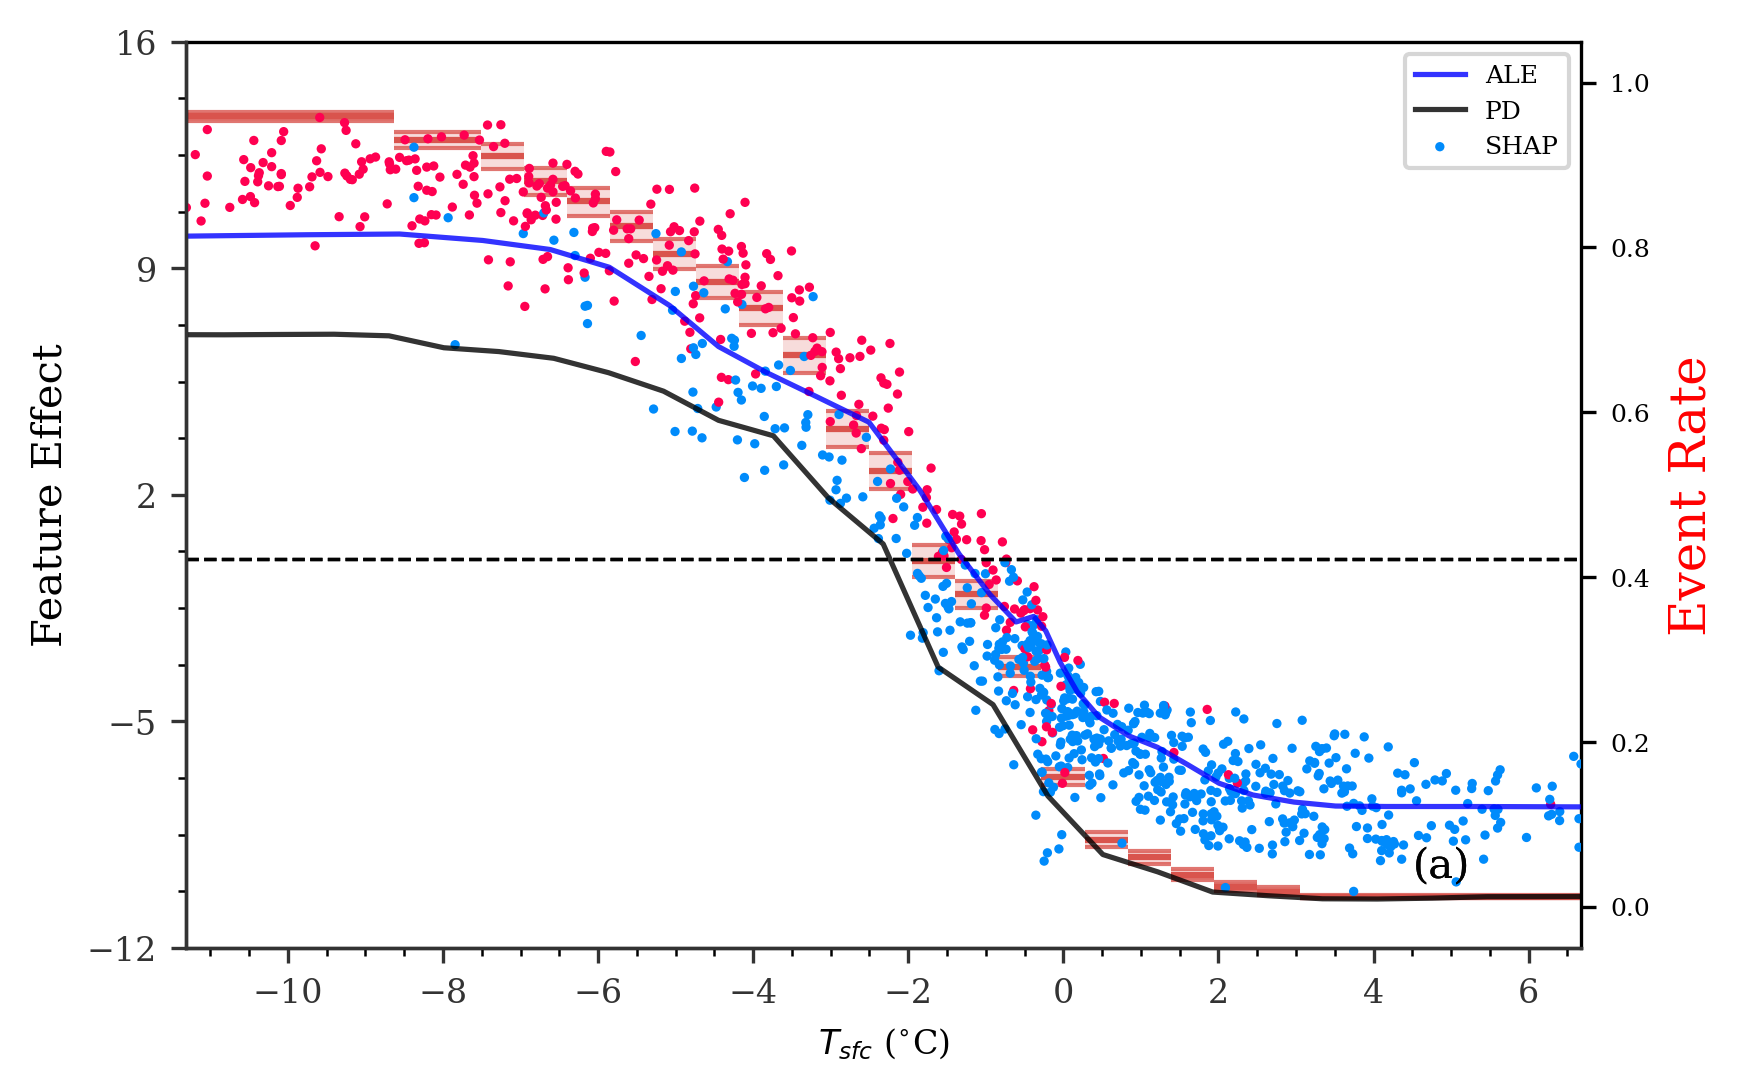

In [39]:
fig, ax = plt.subplots(dpi=300,)
fig.patch.set_facecolor('white')

feature =['sfc_temp']

explainer.plot_ale(ale_1d_ds, 
                   features = feature,
                   estimator_names = ['Random Forest'],
                   add_hist=False, 
                   line_colors=['b'],
                  display_feature_names=plotting_config.display_feature_names,
                  display_units = plotting_config.display_units,
                  ax=ax,)

# Set add_hist == False since it is already included above.
explainer.plot_pd(pd_1d_ds, 
                  features = feature,
                  estimator_names = ['Random Forest'], 
                  ax=ax, line_colors=['k'], 
                  add_hist=False, 
                  display_feature_names=plotting_config.display_feature_names,
                  display_units = plotting_config.display_units,
                 )

histdata = X.copy()
histdata['target'] = y

explainer.plot_shap(features=feature,
                    plot_type = 'dependence',
                    shap_values=results,
                    estimator_name = 'Random Forest',
                    display_feature_names=plotting_config.display_feature_names,
                    display_units = plotting_config.display_units,
                    target_values = y_subset, 
                    interaction_index=None,
                    ax=ax,
)

# plot it up
data = X[feature[0]].values.astype(float)
bin_edges, beta_dist = bayesian_histogram(data, y,)

ax_twin = make_twin_ax(ax)
ax_twin.set_ylabel('Event Rate', color='r')

plot_bayesian_histogram(bin_edges, beta_dist, ax=ax_twin, color = 'xkcd:pale red')

ax.set_ylabel('Feature Effect', fontsize=10)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['ALE', 'PD', 'SHAP'])